In [12]:
import numpy as np 
import pandas as pd
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', 
                 delimiter=',', index_col='Date')
df.index = pd.to_datetime(df.index)
# pd.date_range(start='1981-01-01', end='1990-12-31')
df = df.asfreq(freq='D')
df['Temp'] = df['Temp'].interpolate()
df['Temp'] = np.where(df['Temp']<=0, 0.00001, df['Temp'])
df.head()
df.tail()
df.shape
df.isnull().sum()


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


(3652, 1)

Temp    0
dtype: int64

<AxesSubplot:xlabel='Date'>

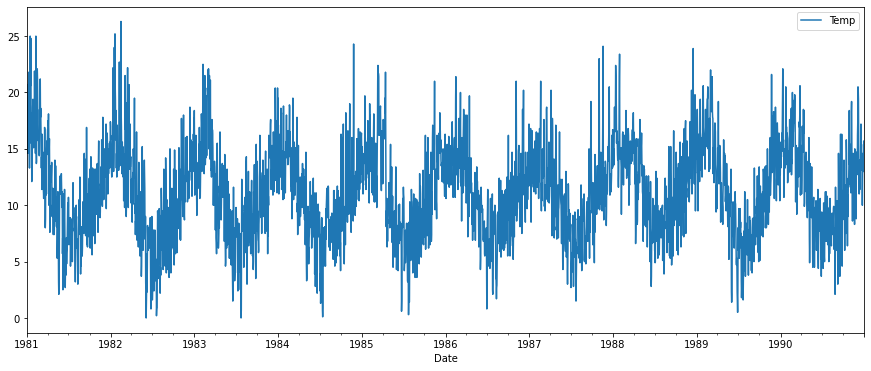

In [6]:
df.plot(figsize=(15, 6))

In [7]:
df['1st_diff'] = df['Temp'].diff()

<AxesSubplot:xlabel='Date'>

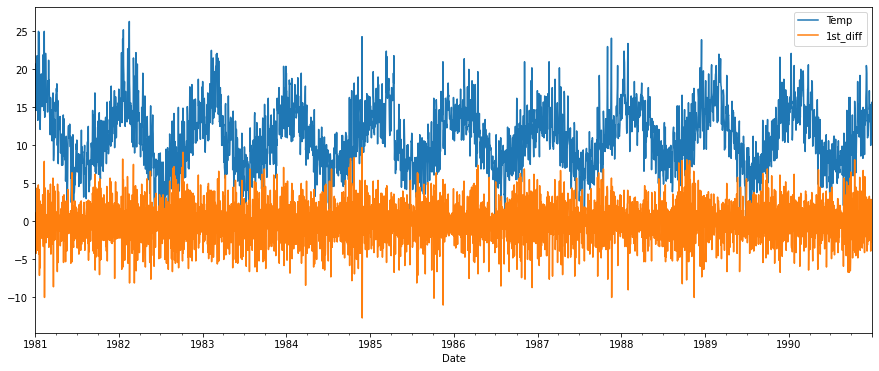

In [8]:
df.plot(figsize=(15, 6))

In [9]:
df['log_Temp'] = np.log(df['Temp'])

<AxesSubplot:xlabel='Date'>

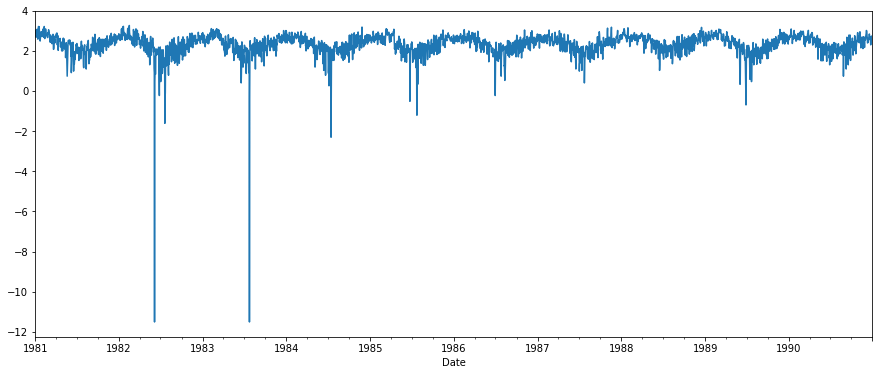

In [11]:
df['log_Temp'].plot(figsize=(15, 6))

In [13]:
N_test = 300
train = df.iloc[:-N_test, :]
test = df.iloc[-N_test:, :]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]


In [14]:
arima = ARIMA(train['Temp'], order=(1,0,0))

In [15]:
arima_res = arima.fit()

In [16]:
df.loc[train_idx, 'AR(1)'] = arima_res.predict(start=train.index[0], end=train.index[-1])

<AxesSubplot:xlabel='Date'>

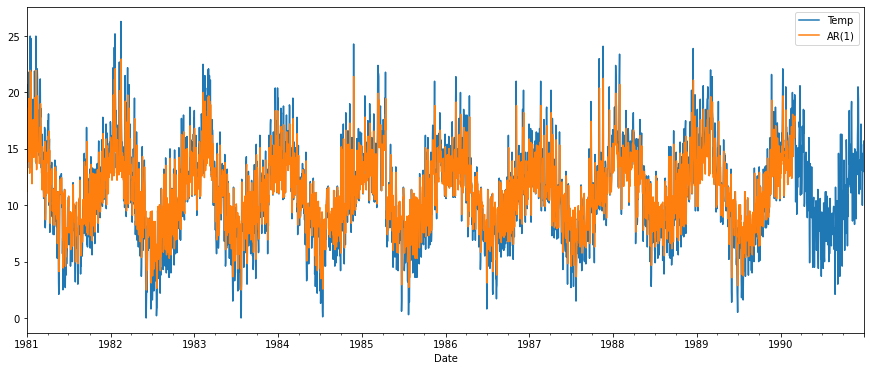

In [17]:
df[['Temp', 'AR(1)']].plot(figsize=(15, 6))

In [18]:
pred_res = arima_res.get_forecast(N_test)
forecast = pred_res.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast


<AxesSubplot:xlabel='Date'>

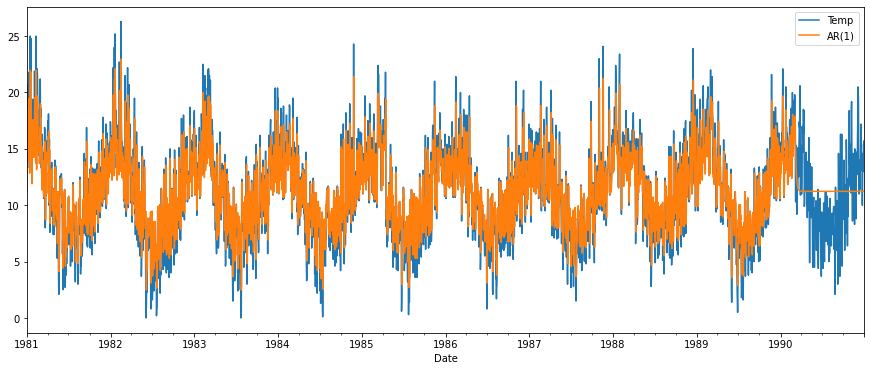

In [19]:
df[['Temp', 'AR(1)']].plot(figsize=(15, 6))
# not a good fit

In [20]:
type(pred_res)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [21]:
# get confidence interval
pred_res.conf_int()

,lower Temp,upper Temp
1990-03-07,10.819119,20.943063
1990-03-08,8.437020,21.270289
1990-03-09,6.939241,21.167310
1990-03-10,5.924053,20.935501
1990-03-11,5.210313,20.677822
...,...,...
1990-12-27,3.158847,19.305042
1990-12-28,3.158847,19.305042
1990-12-29,3.158847,19.305042
1990-12-30,3.158847,19.305042


In [38]:
def plot_fit_and_forecast(res):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df['Temp'], label='data')
    
    # plot the curve fitted on trainset
    train_pred = res.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')
    
    # forecast the testset
    pred_res = res.get_forecast(N_test)
    conf_int = pred_res.conf_int()
    lower, upper = conf_int['lower Temp'], conf_int['upper Temp']
    forecast = pred_res.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
    
    ax.legend()
    
    
def plot_fit_and_forecast_int(res, d, col='Temp'):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df[col], label='data')
    
    # plot the curve fitted on trainset
    train_pred = res.predict(start=train.index[d], end=train.index[-1])
    ax.plot(train.index[d:], train_pred, color='green', label='fitted')
    
    # forecast the testset
    pred_res = res.get_forecast(N_test)
    conf_int = pred_res.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = pred_res.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
    
    ax.legend()
    

def rmse(res, is_logged):
    forecast = res.forecast(N_test)
    if is_logged:
        forecast = np.exp(forecast)
        
    t = test['Temp']
    y = forecast
    return np.sqrt(np.mean((t - y) ** 2))
    

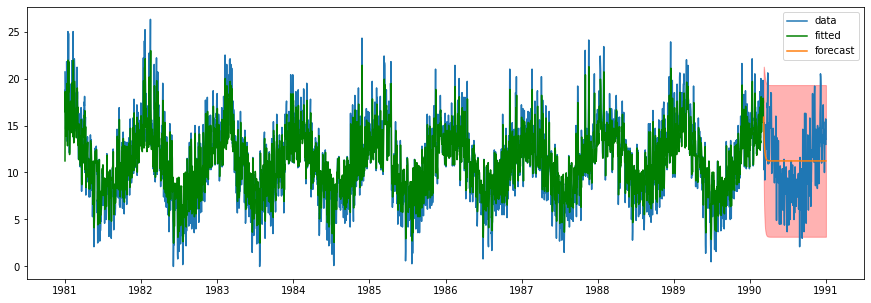

In [23]:
plot_fit_and_forecast(arima_res)

### AR(10)

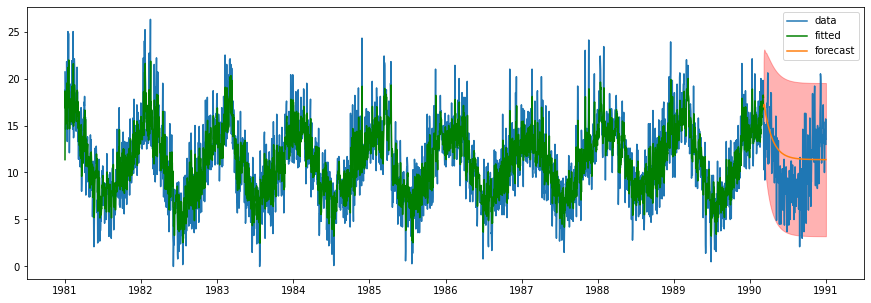

In [24]:
arima = ARIMA(train['Temp'], order=(10,0,0))
arima_res = arima.fit()
plot_fit_and_forecast(arima_res)


### AR(100)

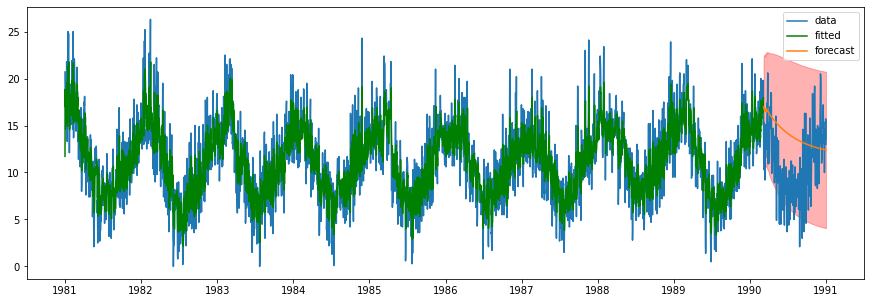

In [28]:
arima = ARIMA(train['Temp'], order=(30,0,0))
arima_res = arima.fit()
plot_fit_and_forecast(arima_res)


### MA(1)


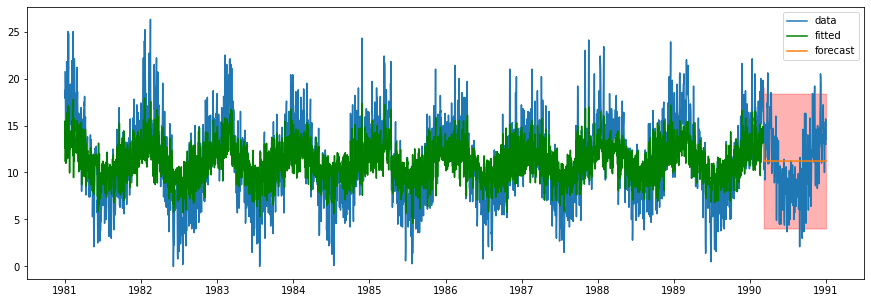

In [27]:
arima = ARIMA(train['Temp'], order=(0,0,1))
arima_res = arima.fit()
plot_fit_and_forecast(arima_res)


### Log

<AxesSubplot:xlabel='Date'>

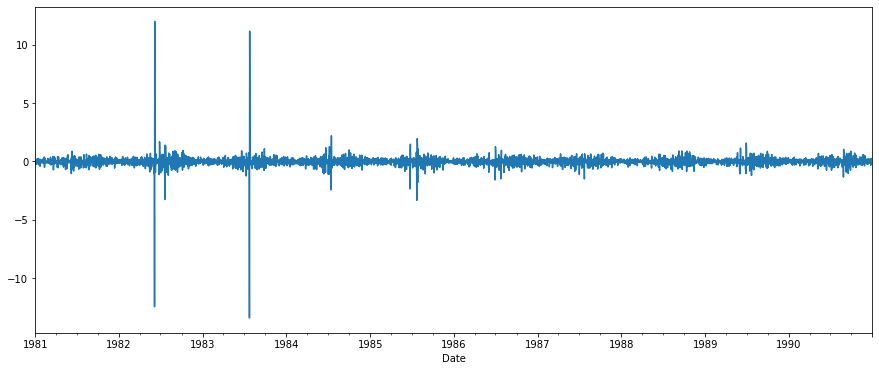

In [26]:
df['log_1st_diff'] = df['log_Temp'].diff()
df['log_1st_diff'].plot(figsize=(15, 6))

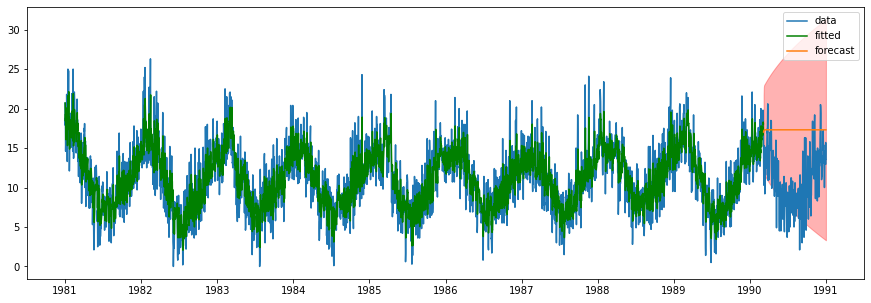

In [34]:
arima = ARIMA(train['Temp'], order=(8,1,1))
arima_res = arima.fit()
plot_fit_and_forecast_int(arima_res, 1)


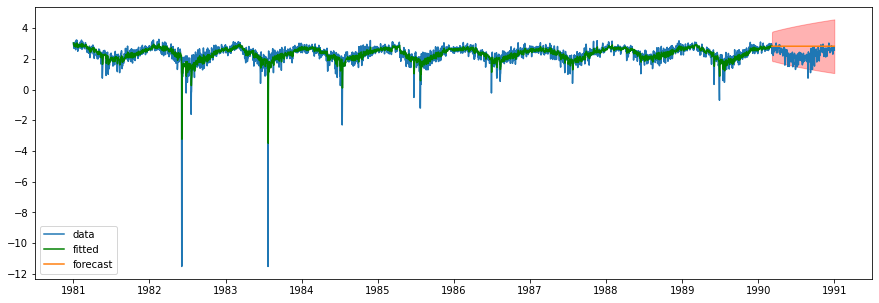

In [35]:
arima = ARIMA(train['log_Temp'], order=(8,1,1))
arima_res = arima.fit()
plot_fit_and_forecast_int(arima_res, 1, col='log_Temp')


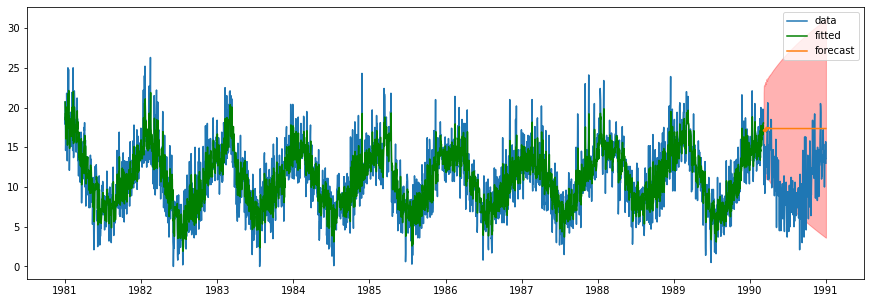

In [36]:
arima = ARIMA(train['Temp'], order=(30,1,0))
arima_res = arima.fit()
plot_fit_and_forecast_int(arima_res, 1, col='Temp')


In [39]:
print('ARIMA(8,1,1):', rmse(arima_res_811, False))


ARIMA(8,1,1): 7.4654316408470915
